In [201]:
import os
import pandas as pd
import git
import matplotlib.pyplot as plt
import folderstats
import numpy as np
import math

folder = "../../data/format-corpus"
relative_path = '../../data/format-corpus'
repo = git.Git(folder)

N_individual = 2044

In [202]:
def expected_operations(N,k,p):
    if(k==0.0):
        k=N
    number_of_pools = np.ceil(N/k)
    number_of_positive_pools = (1 - np.power((1-p),k)) * number_of_pools
    return np.ceil(number_of_pools + number_of_positive_pools*k)

def expected_writes(N,k,p):
    if(k==0.0):
        k=N
    number_of_pools = np.ceil(N/k)
    return number_of_pools

def expected_scrubbing(N,k,p):
    if(k==0.0):
        k=N
    number_of_pools = np.ceil(N/k)
    number_of_positive_pools = (1 - np.power((1-p),k))* number_of_pools
    return np.ceil(number_of_positive_pools*k)

def optimal_pool_size(N,p):
    if(p<=0.0):
        return N
    return np.ceil(1.24*np.power(p,-0.466))

In [203]:
p=0.005
p_meta = 0.8

In [204]:

df = folderstats.folderstats(folder, ignore_hidden=True,hash_name="sha256")
df = df[df.folder==False]
print(df.shape[0])
df["p"]=p
metadata = df.copy()
metadata["p"]=p_meta
metadata["name"]=metadata["name"]+".meta"
metadata["extension"]= "metadata"
df = pd.concat([df,metadata],ignore_index=True)
df["extension"].value_counts()


1560


metadata    1560
xml          986
pdf          106
md            74
mov           61
            ... 
sha1           1
qpw            1
123            1
opml           1
cdd            1
Name: extension, Length: 91, dtype: int64

In [205]:


s1 = df["extension"].value_counts().rename("N")
s2 = df.groupby(["extension"])["p"].mean()
df_ = pd.concat([s1, s2], axis=1)
df_

,N,p
metadata,1560,0.800
xml,986,0.005
pdf,106,0.005
md,74,0.005
mov,61,0.005
...,...,...
sha1,1,0.005
qpw,1,0.005
123,1,0.005
opml,1,0.005


In [206]:
df_["T"] = df_.apply(lambda row:  expected_operations(row.N,optimal_pool_size(row.N,row.p),row.p),axis=1)

N=df_["N"].sum()
p=df_["p"].mean()
k=optimal_pool_size(N,p)

# print("Operations with context sensitive={}".format(df_["T"].sum()))
# print("Efficiency with context sensitive={}".format(N_individual/df_["T"].sum()))
# print("Operations with 2-stages={}".format(expected_operations(N,k,p)))
# print("Efficiency with 2-stages={}".format(N_individual/expected_operations(N,k,p)))

In [207]:
def x(p,p_meta):
    df = folderstats.folderstats(folder, ignore_hidden=True,hash_name="sha256")
    df = df[df.folder==False]
    df["p"]=p
    metadata = df.copy()
    metadata["p"]=p_meta
    metadata["name"]=metadata["name"]+".meta"
    metadata["extension"]= "metadata"
    df = pd.concat([df,metadata],ignore_index=True)
    df["name"].value_counts()

    s1 = df["extension"].value_counts().rename("N")
    s2 = df.groupby(["extension"])["p"].mean()
    df_ = pd.concat([s1, s2], axis=1)
    df_["T"] = df_.apply(lambda row:  expected_operations(row.N,optimal_pool_size(row.N,row.p),row.p),axis=1)

    N=df_["N"].sum()
    p=df_["p"].mean()
    k=optimal_pool_size(N,p)

    # print("Operations with context sensitive={}".format(df_["T"].sum()))
    # print("Efficiency with context sensitive={}".format(N_individual/df_["T"].sum()))
    # print("Operations with 2-stages={}".format(expected_operations(N,k,p)))
    # print("Efficiency with 2-stages={}".format(N_individual/expected_operations(N,k,p)))
    return N_individual/expected_operations(N,k,p)

In [214]:
def xx(p,p_meta):
    df = folderstats.folderstats(folder, ignore_hidden=True,hash_name="sha256")
    df = df[df.folder==False]
    df["p"]=p
    metadata = df.copy()
    metadata["p"]=p_meta
    metadata["name"]=metadata["name"]+".meta"
    metadata["extension"]= "metadata"
    df = pd.concat([df,metadata],ignore_index=True)
    df["name"].value_counts()

    s1 = df["extension"].value_counts().rename("N")
    s2 = df.groupby(["extension"])["p"].mean()
    df_ = pd.concat([s1, s2], axis=1)
    df_["T"] = df_.apply(lambda row:  expected_operations(row.N,optimal_pool_size(row.N,row.p),row.p),axis=1)

    N=df_["N"].sum()
    p=df_["p"].mean()
    k=optimal_pool_size(N,p)

    # print("Operations with context sensitive={}".format(df_["T"].sum()))
    # print("Efficiency with context sensitive={}".format(N_individual/df_["T"].sum()))
    # print("Operations with 2-stages={}".format(expected_operations(N,k,p)))
    # print("Efficiency with 2-stages={}".format(N_individual/expected_operations(N,k,p)))
    return N_individual/df_["T"].sum()

In [215]:
df = pd.DataFrame({"p":np.linspace(0.001,0.05,40),"p_meta":np.linspace(0.99,0.8,40)})
df["T(S)"] = df.apply(lambda row: x(row.p,row.p_meta),axis=1)
df["T(S_context)"] = df.apply(lambda row: xx(row.p,row.p_meta),axis=1)
df

,p,p_meta,T(S),T(S_context)
0,0.001000,0.990000,3.101669,0.761550
1,0.002256,0.985128,2.953757,0.750918
2,0.003513,0.980256,2.838889,0.743003
3,0.004769,0.975385,2.728972,0.735252
4,0.006026,0.970513,2.627249,0.730261
5,0.007282,0.965641,2.532838,0.725337
6,0.008538,0.960769,2.468599,0.719972
7,0.009795,0.955897,2.393443,0.716439
8,0.011051,0.951026,2.325370,0.712443
9,0.012308,0.946154,2.261062,0.708001


In [209]:
from mpl_toolkits.mplot3d import Axes3D

C:\Users\User\AppData\Local\Temp/ipykernel_30552/2120400345.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure().gca(projection='3d')


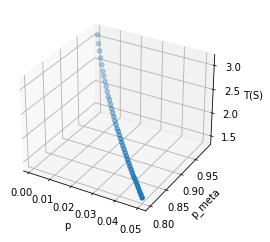

In [210]:
threedee = plt.figure().gca(projection='3d')
threedee.scatter(df.p, df.p_meta, df["T(S)"])
threedee.set_xlabel('p')
threedee.set_ylabel('p_meta')
threedee.set_zlabel('T(S)')
plt.show()

In [211]:

df_["k"] = df_.apply(lambda row: optimal_pool_size(row.N,row.p),axis=1)
df_["T(S)"] = df_.apply(lambda row:  expected_operations(row.N,1,row.p)/expected_operations(row.N,row.k,row.p),axis=1)
df_["T"] = df_.apply(lambda row:  expected_operations(row.N,row.k,row.p),axis=1)
df_["T_N"] = df_.apply(lambda row:  expected_operations(row.N,1,row.p),axis=1)
df_["T(S_writes)"] = df_.apply(lambda row: expected_writes(row.N,1,row.p)/expected_writes(row.N,row.k,row.p),axis=1)
df_["T(S_scrubbing)"] = df_.apply(lambda row: expected_scrubbing(row.N,1,row.p)/expected_scrubbing(row.N,row.k,row.p),axis=1)
df_["T(S_scrubbing)"] = df_["T(S_scrubbing)"].fillna(1)

In [212]:
df_["T_N"].sum()/df_["T"].sum()

1.6302829841969864

In [213]:
print("Efficiency reached with context sensitive pooling={}".format(df_["T(S)"].mean()))
print("Operations needed with context sensitive pooling={}".format(df_["T"].sum()))

N=df_["N"].sum()
p=df_["p"].mean()
k=optimal_pool_size(N,p)
print(N)
print(p)
print(k)
print("Expected Efficiency with 2-stages={}".format(N_individual/expected_operations(N,k,p)))
print("Operations with 2-stages={}".format(expected_operations(N,k,p)))
expected_operations(N,k,p)

Efficiency reached with context sensitive pooling=1.5944595174010754
Operations needed with context sensitive pooling=2721.0
3094
0.013736263736263734
10.0
Expected Efficiency with 2-stages=2.8748241912798873
Operations with 2-stages=711.0


711.0